# Welcome to the NS-Gym Tutorial!


The goal of this tutorial is to get you started using NS-Gym to make NS-MDPs.

We will:

1. Learn the basic steps to create a NS-MDP using NS-Gym.
2. Walkthrough a simple example how one might use NS-Gym to evaluate policy perfomacnce on NS-MDPs.
3. Create our own custom NS-MDP using NS-Gym.


## Installation

Typically we can pip install from github but for the purposes of this submission please refer to this read me for installation instructions: [README.md](README.md)

## Let's import the ns_gym package and other useful packages

In [1]:

# This is our Wrapper
import ns_gym as nsg

# Of course we need to import gymnasium
import gymnasium as gym

# Other useful packages for analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ns_gym.utils import type_mismatch_checker
import copy

%matplotlib inline

# A simple motivating example: Non-stationary FrozenLake

Let's take a look at as simple motivating case where we learn a deteministic value iteratoin policy on stationary frozen lake.

Value iterattion is dynamic programming approach to solve for the expected long term reward of a cell given the optimal policy. For demonstration purposses we have an an implemation below. In this example this serves as our **decision-making agent**.

For now let us assume this agent only has a decision making agent only has access to a planning module with no "runtime monitor" or "model updater" component. We will revisit how NS-Gym might simulate these two components later.



In [9]:


def value_iteration(env, gamma=0.9, theta=1e-6):
    """
    Perform value iteration on a Gymnasium environment.

    Args:
        env: The Gymnasium environment (assumed to be FrozenLake).
        gamma: The discount factor.
        theta: A threshold for stopping the value iteration.

    Returns:
        policy: The optimal policy.
        V: The value function for each state.
    """
    # Initialize value function
    V = np.zeros(env.unwrapped.observation_space.n)

    while True:
        delta = 0
        # Update each state's value
        for state in range(env.unwrapped.observation_space.n):
            # Compute the maximum expected value over all possible actions
            v = V[state]
            new_v = max(
                sum(prob * (reward + gamma * V[next_state])
                    for prob, next_state, reward, _ in env.unwrapped.P[state][action])
                for action in range(4)
            )
            # Update the value function
            V[state] = new_v
            # Update the delta
            delta = max(delta, abs(v - new_v))

        # Check for convergence
        if delta < theta:
            break

    # Extract the optimal policy
    policy = np.zeros(env.unwrapped.observation_space.n, dtype=int)
    for state in range(env.unwrapped    .observation_space.n):
        # Select the action with the highest expected value
        policy[state] = np.argmax([
            sum(prob * (reward + gamma * V[next_state])
                for prob, next_state, reward, _ in env.unwrapped.P[state][action])
            for action in range(4)
        ])

    return policy, V


## A quick intro to the standard Gymnasium API and workflow

In Gymnasium, an environment represents a Markov Decision Process (MDP). It provides a framework where an agent interacts with an environment by taking actions, observing states, and receiving rewards. Here’s a breakdown of key components:

**Environment** Object: This represents the MDP. It includes a set of states, a set of possible actions, and defines the rules for state transitions and rewards based on the agent's actions.

**Observation**: Represents the information the agent receives about the current state. It may not always provide complete information about the true state, depending on the environment's design.

**Info**: This is an optional dictionary that provides extra diagnostic information helpful for debugging or understanding the environment's behavior. It's not used directly for learning but can provide insights.

### Step 1) Initialization

The environment is first initialized to set up the state


In [10]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array",is_slippery=False)

### Step 2) Interaction Loop

The agent interacts with the environment in a loop:

* Receives an observation of the current state.
* Chooses an action based on the observation.
* Executes the action using env.step(action), which returns:

    * The next observation.
    * A reward for the action taken.
    * A done flag indicating if the agent has reached a terminal state.
    * A truncated flag indicating if the episode has elapsed for a maximum number of steps.
    * The info dictionary.

If `done` is True, the environment is reset for a new episode.

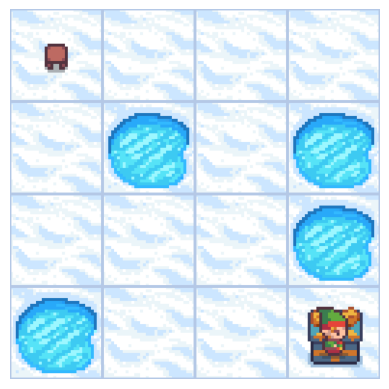

In [ ]:
#Let's grab the stationary policy  -- our AGENT


def run_episode(env, policy, visulalize=True,non_stationary_env=False):

    # Reset environment
    observation, info = env.reset()
    observation, _ = type_mismatch_checker(observation)

    # Set done and truncated flags to false
    done = False
    truncated = False
    episode_reward = 0

    parameter_list = []

    if non_stationary_env:
        parameter_list.append(copy.copy(env.transition_prob))

    while not done and not truncated:

        ###############  Main agent-environment interaction #######
        action = policy[observation]
        observation, reward, done, truncated, _ = env.step(action)
        observation, reward = type_mismatch_checker(observation,reward)
        episode_reward += reward


        if non_stationary_env:
            parameter_list.append(copy.copy(env.transition_prob))

        #############################################################

        if visulalize:
            ####### Vizulaize agent in environment##########################
            # Clear the previous output , for visualization
            clear_output(wait=True)
            output= env.render()
            plt.imshow(output)
            plt.axis('off')  # Hide axes
            plt.show()
            #############################################################
            time.sleep(0.3)

    return episode_reward,parameter_list

stationary_policy, stationary_V = value_iteration(env.unwrapped)

# for i in range(5):
#     run_episode(env,stationary_policy)





# **Integrating NS-Gym** -- what if at each decision epoch the environment becomes more slippery?

We can capute the change in this environmental parameter with the NS-Gym package.

The agent environment set up is essentially follows the same Gymnasium interface with few other considerations. There are finer details that we will go over for a bit but the general experimental pipeline is as follows:



1. **Create Standard Environment**: Start by creating a typical Gymnasium environment.
2. **Define Update Parameters**: Identify environmental parameters to be updated during the episode.
3. **Map Schedulers & Update Functions**: Assign schedulers and update functions to each parameter.
4. **Generate Non-Stationary Environment**: Use the NS-Gym wrapper to combine the standard environment with the parameter mappings, creating a non-stationary environment.





## Step 1) Create a standard Gymnasium environment

We initialized the Gymnasium Frozen Lake environment above but for completeness we can do it again here.

In [2]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array",max_episode_steps=50)

## Step 2) Define Update Parameters


NS-Gym in at a high level lets users design non-stationary marchov decision processes by modifiing exposed paramters of some base Gymnasium environment.

The table below lists all environments and set of observable parameters that can be tuned by NS-Gym to induce non-stationarity.

| Env | What are the tunable parameters (AKA the hidden theta) |
| --- | -------------------------------------------------------|
| Acrobot|"dt","LINK_LENGTH_1","LINK_LENGTH_2","LINK_MASS_1","LINK_MASS_2","LINK_COM_POS_1","LINK_COM_POS_2","LINK_MOI"|
| Cartpole|"gravity","masscart","masspole","force_mag","tau","length"|
| Mountain Car | 'force','gravity'|
| Pendulum |'dt', 'g','l', 'm',|
| Frozen Lake |'P' (P is a probablity table that defines a categorical distribution for each state action pair)|
| Cliff Walking |'P'|
| Bridge | "P", "left_side_prob","right_side_prob" |









In [3]:
####### Defining environmental parameters ############
param = "P"




## Set 3 Map Schedulers and Parameter Update Functions

In addition to a wrapper, the two other essential components of the package are schedulers and pupdate functions.

- **Schedulers:** Functions (really callables) that define **when** to update the value of an environment transition function. They simply return a boolean flag at time steps where the paramters need to updated.
- **Update Function:** Defines **how** to update the value of a parameter or probability distribution. If the scheduler returns true, update the parameter accordingly.


Seperating each component allows for greater flexibility and in designing experiments.

Availble schedulers are found under `ns_gym/schedulers.py`. Parameter update functions are found under the `ns_gym/update_functions` directory.

In this case we want the **frequency** of our updates to be at each MDP step. So let's import the `ContinuousScheduler`.

We can decrease the probability of going in the direction by some constant using the `DistributionDecrmentUpdate`.



In [4]:
from ns_gym.schedulers import ContinuousScheduler,DiscreteScheduler
from ns_gym.update_functions import DistributionDecrementUpdate

### Define the scheduler #######
scheduler = ContinuousScheduler() #Update the slipperiness at each timestep

#### Define the update function #####
update_function = DistributionDecrementUpdate(scheduler=scheduler,k = 0.1) #Decrement the slipperiness by 0.1 at each timestep where the scheduler fires true

# Map parameter to update function

params = {param:update_function}




## Step 4) Generate a Non-Stationary Environment



NS-Gym provides wrappers for the Clasic control suite of Gymnasium  environments and three gridworld environments. At each time step these wrappers will modfify the value of the environment parameter thereby altering the transition function of the MDP. Aditionally, the wrapper can can control the level of notification available to decision making agent when there is a change to the tranition function.  

The available wrappers are as follows:

- The `NSClassicControlWrapper` is compatable with all environments in the classic control suite of environments.
- The `NSCliffWalkingWrapper` augments the CliffWalking environment.
- The `NSFrozenLakeWrapper` augments the FrozenLake environment.
- The `NSBridgeWrapper` augments the Bridge environment.

Wrappers are found under the `ns_gym.wrappers` subpackage

In [5]:
###### Import the frozen lake
from ns_gym.wrappers import NSFrozenLakeWrapper

ns_env = NSFrozenLakeWrapper(env,params, initial_prob_dist=[1,0,0])

# Observing our now stale policy on this non-stationary environment




In [6]:

def plot_parameter_over_time(parameter_values, final_reward):
    """
    Plots the parameter values over time, color-coded by the final reward.

    Args:
        parameter_values (list or array): The parameter values over time.
        final_reward (float): The final reward earned by the policy.
    """
    time = np.arange(len(parameter_values))

    # Create a color map based on the final reward
    intended_direction_prob = [p[0] for p in parameter_values]
    plt.plot(time, intended_direction_prob)
    plt.xlabel('Time')
    plt.ylabel('Transition Probability')
    plt.title(f'Final Reward: {final_reward}')
    plt.show()

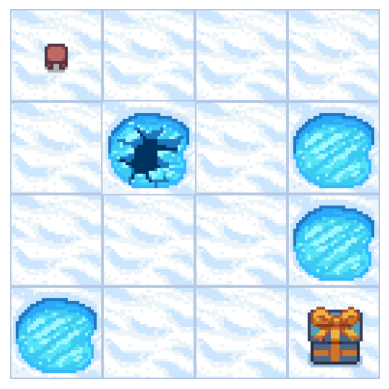

In [12]:
for trial in range(5):
    episode_reward,param_list = run_episode(ns_env,stationary_policy,non_stationary_env=True)



## One question we can answer using NS-Gym is how will different magnitudes of change affect the perfomance of our decision making agent?



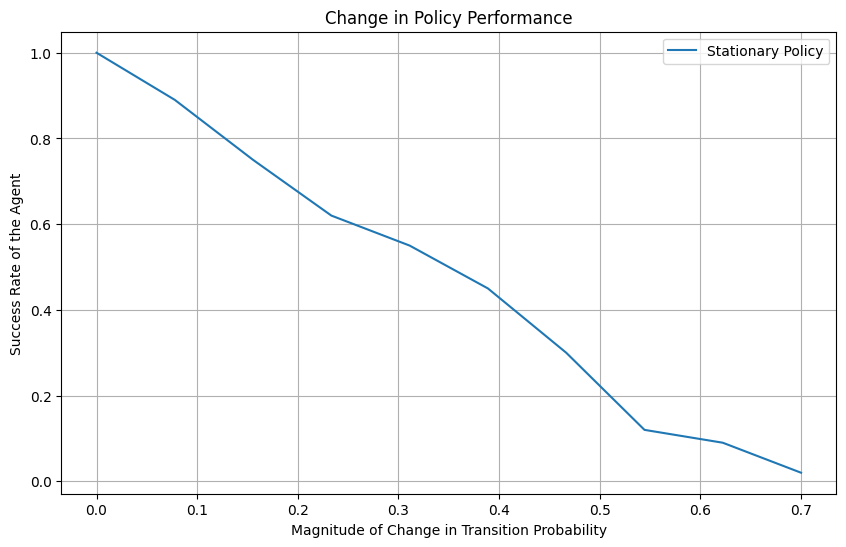

In [11]:


def run_experiment(episode_runner,change_notification=False,delta_change_notification=False):
    lookup_table = {}

    for k in np.linspace(0,0.7,10):

            ## Initialize the environement
            env = gym.make('FrozenLake-v1',render_mode="rgb_array",max_episode_steps=50)

            ### Define the scheduler #######
            # scheduler = ContinuousScheduler() #Update the slipperiness at each timestep
            # scheduler = ContinuousScheduler(start =1,end=1 )
            scheduler = DiscreteScheduler({1})
            #### Define the update function #####
            update_function = DistributionDecrementUpdate(scheduler=scheduler,k = k) #Decrement the slipperiness by 0.1 at each timestep where the scheduler fires true

            # Map parameter to update function
            params = {param:update_function}

            # Wrap the environment
            ns_env = NSFrozenLakeWrapper(env, params, change_notification,delta_change_notification,initial_prob_dist=[1,0,0])

            # Define a list to keep track of trial rewards
            trial_reward = []
            for trial in range(100):
                episode_reward,param_list = episode_runner(ns_env,stationary_policy,non_stationary_env=True,visulalize=False)
                trial_reward.append(episode_reward)

            lookup_table[k] = np.mean(trial_reward)
    return lookup_table

def plot_rate_of_change(lookup_tables):

    plt.figure(figsize=(10, 6))

    for name,lookup_table in lookup_tables.items():
        plt.plot(lookup_table.keys(), lookup_table.values())

    plt.title("Change in Policy Performance")
    plt.xlabel("Magnitude of Change in Transition Probability")
    plt.ylabel("Success Rate of the Agent")
    plt.legend(lookup_tables.keys())
    plt.grid(True)
    plt.show()


lookup_table = run_experiment(run_episode)
plot_rate_of_change({"Stationary Policy":lookup_table})



 ### The is a trivial example and the result is to be expected, but what if our decision making agent had access to two more modules?

1. A runtime monitor component
2. A model updater

How would our policy perform is say between decions we had sufficient time to update our policy given the most up to date version of the environment (though no future versions)?

## Notification Levels and custom observation and reward types.

A key feature of the NS-Gym library is its ability to manage
the interaction between the environment and the decision-
making agent.
Users can configure notifications the agent receives about
changes in the NS-MDP at three distinct levels:
1. **Basic Notification:** The agent receives a boolean flag in
dicating a change in an environment parameter.
2. **Detailed Notification:** In addition to the boolean flag, the
agent is informed of the magnitude of the change.
3. **Full Environment Model:** Additionally, if the agent requires an environmental model for planning purposes (such
as in Monte Carlo tree search), NS-Gym can provide a stationary snapshot of the environment. This snapshot aligns with the basic or detailed notification settings configured by the user. If the user seeks a model without detailed notification, the planning environment is a stationary snapshot of the base environment. Conversely, if detailed notifications are enabled, the agent receives the most up-to-date version of the environment model (but not any future evolutions)

To handle the different levels of notification NS-Gym has custom Obsevation and Reward types. The base Observation type is outlined below.

```python


@dataclass(frozen=True)
class Observation:
    """Observation dataclass type. This is the output of the step function in the environment.

    Attributes:
        state (Union[np.ndarray,int]): The state of the environment
        env_change (Union[dict[str, bool],bool,None]): A dictionary of boolean flags indicating what param of the environment has changed.
        delta_change (Union[dict[str,float],float]): The amount of change in the transition function of the environment
        relative_time (Union[int,float]): The relative time of the observation since the start of the environment episode.
    """
    state : Union[np.ndarray,int]
    env_change: Union[dict[str, bool],None]
    delta_change: Union[dict[str,float],float,None]
    relative_time: Union[int,float]


```

So let's say that we now have a run time monitor and model updater component. We can simulate a detecting a anomally by way of the ns-gym notificaiton sytem.

In this senerio our environment is still behaving in the same non-stationary way but we are now have a fully updated model of the environment, but no knowledge of future changes.


In [12]:
### Lets incorporate the simulation of a model updater and anomally detection
### with ns_gym notification system

### Set up how the environment changes as we have done previously
env = gym.make('FrozenLake-v1',render_mode="rgb_array",max_episode_steps=50)

### Define the scheduler #######
scheduler = ContinuousScheduler() #Update the slipperiness at each timestep

#### Define the update function #####
update_function = DistributionDecrementUpdate(scheduler=scheduler,k = 0.1) #Decrement the slipperiness by 0.1 at each timestep where the scheduler fires true

# Map parameter to update function
params = {param:update_function}


For this scenerio we want two things:

1. We "notified" that the environment changed so that we can retrain our model
2. We need the most upt to date verision of the evironment to extract the policy.

We can acheive this by setting the `change_notification` and `delta_change_notification` keywork parameters to `True` in our FrozenLake wrapper.

By setting these wrapper parameters to true we have access the `env_change` and `delta_env` change fields of observation.

In [16]:
# Wrap the environment
ns_env = NSFrozenLakeWrapper(env,
                             params,
                             change_notification=True,
                             delta_change_notification=True,
                             initial_prob_dist=[1,0,0])

Let's set up our new interaction loop this time updating our policy every time receive our change notification. Below I copy and pasted our agent-environment interaction loop from before.

In [17]:
def run_episode_with_notification(env, policy, visulalize=True,non_stationary_env=False):

    # Reset environment
    observation, info = env.reset()
    observation, _ = type_mismatch_checker(observation)

    # Set done and truncated flags to false
    done = False
    truncated = False
    episode_reward = 0

    parameter_list = []

    if non_stationary_env:
        parameter_list.append(copy.copy(env.transition_prob))

    while not done and not truncated:

        ###############  Main agent-environment interaction #######
        action = policy[observation]
        observation, reward, done, truncated, info = env.step(action)

        ### Check if the environment has changed ###
        ## then update to a more uptodate policy)
        if observation["env_change"]["P"]:
            policy,_ = value_iteration(env)



        observation, reward = type_mismatch_checker(observation,reward)
        episode_reward += reward


        if non_stationary_env:
            parameter_list.append(copy.copy(env.transition_prob))

        #############################################################

        if visulalize:
            ####### Vizulaize agent in environment##########################
            # Clear the previous output , for visualization
            clear_output(wait=True)
            output= env.render()
            plt.imshow(output)
            plt.axis('off')  # Hide axes
            plt.show()
            #############################################################
            time.sleep(0.3)

    return episode_reward,parameter_list



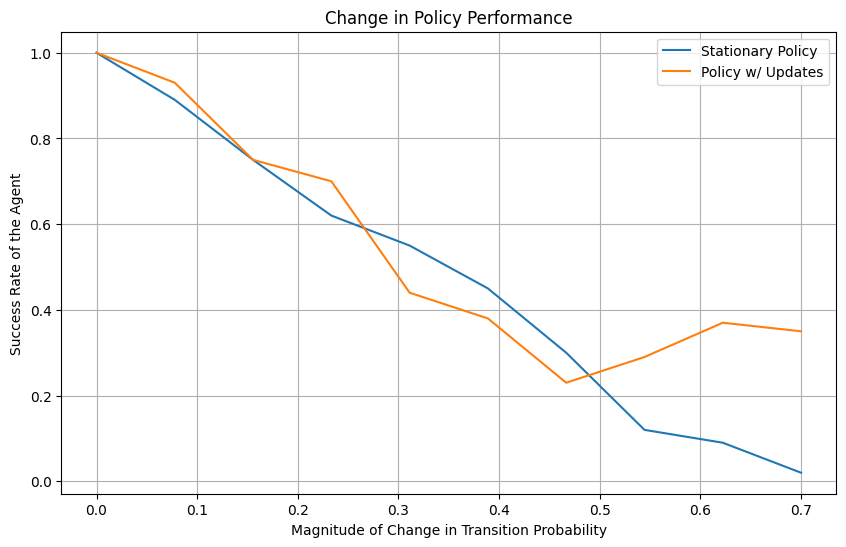

In [18]:
notification_lookup_table = run_experiment(run_episode_with_notification,change_notification=True,delta_change_notification=True)

data = {"Stationary Policy":lookup_table,
        "Policy w/ Updates":notification_lookup_table}

plot_rate_of_change(data)

Although this is a minimal working example, this illustrates how one might use NS-Gym to benchmark policies under different conditions of non-stationarity.

# Constructing Custom NS-MDPs

It is easy to construct custom NS-MDPS with NS-Gym to fit your use case via the implementation of custom scheduler and update functions.

Lets say rather than a single discrete time environment parameter update we want the frequency in our updates to also be stochatic.

Furthermore, we would like the slipperiness of the system to oscillate between a determenisitc one and a stochastic one.



## Custom Scheduler
One can easily implement their own custom scheduler. The scheduler just needs to be a callable that takes in the current time and outputs a boolean. It also needs to be a subclass of `ns_bench.base.Scheduler`. This sample custorm scheduler will "fire" with probability 0.25.

In [20]:
### Custom Scheduler just needs to be a callable that takes in the current time and outputs a boolean. It also needs to be a subclass of ns_bench.base.Scheduler

# Base classes are found here
import ns_gym.base as base

class StochasticScheduler(base.Scheduler):
    def __init__(self,start=0,end=np.inf) -> None:
        super().__init__(start,end)

    def __call__(self,t):
        """This is where we define when the schedulers should fire.

        Args:
            t (Union[int,float]): The current time step

        Returns:
            bool: True if the scheduler should fire, False otherwise
        """
        return np.random.choice([True,False],p=[0.25,0.75])



stochastic_scheduler = StochasticScheduler()

## We can test it here

count_true = 0

for i in range(300):
    if stochastic_scheduler(i):
        count_true +=1

print(f"The scheduler fires {count_true/300} percent of the time")


The scheduler fires 0.2966666666666667 percent of the time


## Custom Update Function

We can also define a custom update function. We can define a parameter update function as a callable class. The the parameter update function is a subclass of `ns_gym.base.UpdateFn` if its a scalar parameter update. If we are modifying a probability `ns_gym.base.UpdateDistributionFn`. We initialize the update function with its associated scheduler then all we need to implement it the `update` method. The update function will only "fire" when the scheduler returns true. If there is no update, the `ns_gym.base.UpdateFn` will return the parameter with no change.

All update functions return a three tuple `(param, update_bool, parameter_update_amount)`

```
    Returns:
            Any: The updated parameter
            bool: Boolean flag indicating whether the parameter was updated or not
            float: The amount of change in the parameter
```

This custom update function will return a deterministic function or stochastic distribution depending on the current parameter value.

It's important the note that the first element of a transition probability array always corresonds to the intended outcome of an action.

In [ ]:

class OscillatingParameterUpdater(base.UpdateDistributionFn):
    def __init__(self,scheduler) -> None:
        """

        """
        super().__init__(scheduler)

    def _update(self,param,t):

        if param[0] == 1:
            param[0] = 0.4
            for i in range(1,len(param)):
                param[i] = (1-param[0])/(len(param)-1)
        else:
            param[0] = 1
            for i in range(1,len(param)):
                param[i] = 0

        return param


oscillating_updater = OscillatingParameterUpdater(stochastic_scheduler)

### We can test the out put of out function here;

test_param = [1,0,0]

for t in range(20):
    test_param,change_notif,delta_change = oscillating_updater(test_param,t)

    if change_notif:
        print("The parameter was updated!")
        print(f"The new parameter value is: {test_param}")
        print(f"The change in distribution (Wassestein distance): {delta_change}")

The parameter was updated!
The new parameter value is: [0.4, 0.3, 0.3]
The change in distribution (Wassestein distance): 0.4
The parameter was updated!
The new parameter value is: [1, 0, 0]
The change in distribution (Wassestein distance): 0.4
The parameter was updated!
The new parameter value is: [0.4, 0.3, 0.3]
The change in distribution (Wassestein distance): 0.4
The parameter was updated!
The new parameter value is: [1, 0, 0]
The change in distribution (Wassestein distance): 0.4


In [22]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array",max_episode_steps=50)

param = "P"

custom_ns_mdp_parameters = {param:oscillating_updater}

custom_ns_env = NSFrozenLakeWrapper(env,
                             custom_ns_mdp_parameters,
                             change_notification=True,
                             delta_change_notification=True,
                             initial_prob_dist=[1,0,0])




 # Decision Making Algorithms Included in NS-Gym

NS-Gym includes several decision making algorithms found under the `ns_gym.benchmark_algorithm` subpackage. For illustrative purposes we can test a vanilla Monte Carlo Tree Search (MCTS)  on our custom environment. MCTS needs a model of the environment to do search. We can give the search tree model that matches our notification levels by calling `ns_env.get_planning_env()`. If `delta_change_notification` is set to `True` the tree search algorithm has access to the most up to date version of the environment (though no future evolutions).




In [ ]:
from ns_gym.benchmark_algorithms import MCTS

reward_list = []
for i in range(10):
    episode_reward = 0
    done = False
    truncated = False
    obs,_  = custom_ns_env.reset()

    while not done and not truncated:
        planning_env = custom_ns_env.get_planning_env()
        agent = MCTS(planning_env,obs,d=100,m=100,c=1.44,gamma=0.99)
        action,_ = agent.search()
        obs, reward, done, truncated, info = custom_ns_env.step(action)
        obs, reward = type_mismatch_checker(obs,reward)
        episode_reward += reward

    print(f"Episode {i} reward: {episode_reward}")
    reward_list.append(episode_reward)


print(f"Success Rate for MCTS Agent on Custom Env: {np.mean(reward_list) }")


Episode 0 reward: 1.0
Episode 1 reward: 1.0
Episode 2 reward: 0.0
Episode 3 reward: 0.0
Episode 4 reward: 0.0
Episode 5 reward: 0.0
Episode 6 reward: 0.0
Episode 7 reward: 1.0
Episode 8 reward: 1.0
Episode 9 reward: 1.0
Success Rate for MCTS Agent on Custom Env: 0.5


In [24]:
reward_list = []
for i in range(100):
    episode_reward = 0
    done = False
    truncated = False
    obs,_  = custom_ns_env.reset()
    obs,_  = type_mismatch_checker(obs)

    while not done and not truncated:
        action = stationary_policy[obs]
        obs, reward, done, truncated, info = custom_ns_env.step(action)
        obs, reward = type_mismatch_checker(obs,reward)
        episode_reward += reward

    reward_list.append(episode_reward)


print(f"Success Rate for Stationary Agent on Custom Env: {np.mean(reward_list) }")

Success Rate for Stationary Agent on Custom Env: 0.37


# The NS-Gym Eval Module

In addition to NS-MDP design, NS-Gym’s flexible API lets the programmer access the ”difficulty” of the non-stationary MDPs via a simple function call from the NS-Gym’s eval module.  We include two baseline metrics. The first is an ensemble performance metric which computes the mean reward accross $N$ policies and $\Pi$ policies. For stochastic environments, we also provide a policy-agnostic metric, the PAMCTS-Bound. The PAMCTS-Bound measures the maximum difference in transition functions between two MDPs, $M_0$ and $M_1$.

Below is an example 

Consider designing a non-stationary version of the ”Pendulum” environment, where at each MDP time step, the mass of the pendulum increases by 0.01 units. This environment can be constructed as follows:

In [27]:
env = gym.make("Pendulum-v1")
tunable_param = "m"
scheduler = ContinuousScheduler()
update_fn = nsg.update_functions.IncrementUpdate(scheduler=scheduler,k=0.01)
param_map = {tunable_param:update_fn}
ns_env = nsg.wrappers.NSClassicControlWrapper(env,param_map)

The ensemble evaluator can be simply called as so:

In [28]:
from ns_gym.evaluate.metrics import EnsembleMetric
evaluator = EnsembleMetric()
ensemble_reward, perfomance_dict = evaluator.evaluate(ns_env,100)

Evaluation Results
Ensemble Regret: -917.4094989353425

Agent Regret:
  - TD3: -1195.6729455188877
  - DDPG: -152.44777861672722
  - PPO: -768.8514167420533
  - A2C: -1552.6658548637017


# Simulating Contextual MDP with NS-Gym

Contextual MDPs (C-MDPs) are a related modeling paradigm to NS-MDPs and can easilly be implemented in NS-Gym. Below is an example of how we can define a C-MDP over a specified context and evaluate it using a DQN model from the `Stable-Baseline3` library. 

In [29]:
%pip install ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


In [30]:
from ns_gym.context_switching import make_env_with_context, calculate_generalized_performance
from functools import partial
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DQN
# Let's define the k source contexts to train on 
SOURCE_CONTEXTS = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])

# define fully context range

target_context_min = 0.1
target_context_max = 10.0
num_target_contexts = 100

current_context_range = np.linspace(target_context_min,target_context_max,num_target_contexts)

env_name = "CartPole-v1"
context_param = "masspole"

trained_agents = []
make_env_partial_fn = partial(make_env_with_context, env_name=env_name,context_parameter_name=context_param)

for i, s_ctx in enumerate(SOURCE_CONTEXTS):
    train_env = make_vec_env(lambda: make_env_partial_fn(context_value=s_ctx, seed=i), n_envs=1)
    model = DQN(
        "MlpPolicy", 
        train_env, 
        verbose=0,
        tensorboard_log=None,
        device="auto",
        seed=i
    )


    model.learn(total_timesteps=3000, progress_bar=False)
    trained_agents.append(model)
    train_env.close()



    (U_raw, peaks_raw, overall_raw, sem_raw,
     U_norm, peaks_norm, overall_norm, sem_norm, 
     norm_params)  = calculate_generalized_performance(
            trained_agents,
            SOURCE_CONTEXTS,
            make_env_partial_fn,
            num_episodes_per_eval_context=25,
            evaluation_target_context_range=current_context_range,
            normalize=True
        )






AttributeError: 'float' object has no attribute 'reward'

In [ ]:
print("\n--- Results Summary ---")
print(f"Shape of Performance Matrix U (Raw): {U_raw.shape}")
if U_norm is not None:
    print(f"Shape of Performance Matrix U (Normalized): {U_norm.shape}")

print("\nPeak Performance for each Policy (Raw):")
for i, peak_p in enumerate(peaks_raw):
    print(f"  Agent trained on Ctx {SOURCE_CONTEXTS[i]:.2f}: Max Reward = {peak_p:.2f}")
if peaks_norm is not None:
    print("\nPeak Performance for each Policy (Normalized):")
    for i, peak_p in enumerate(peaks_norm):
        print(f"  Agent trained on Ctx {SOURCE_CONTEXTS[i]:.2f}: Max Reward = {peak_p:.2f}")
    
print(f"\nOverall System Generalized Performance: Mean = {overall_raw:.2f}, SEM = {sem_raw:.4f}")

print(f"Overall System Generalized Performance: Mean = {overall_norm:.2f}, SEM = {sem_norm:.4f}")

